https://link.springer.com/article/10.1007/s13278-022-00998-2

In [78]:
# Textblob
from textblob import TextBlob, Word

# NLTK
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Sklearn
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# Statsmodel
import statsmodels.api as sm

# Python packages
import pickle
import pandas as pd
import numpy as np
import re
import emoji
import string
import datetime as dt

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format="retina"

import warnings
warnings.filterwarnings("ignore")

STOPWORDS_ENGLISH = stopwords.words("english")
pd.set_option('display.max_colwidth', None)

In [3]:
def emoji2dec(tweet):
    """
    Convert emojis into text descriptions.
    Returns processed tweet.
    """
    res = [s.strip() for s in emoji.demojize(tweet).split(":") if s != ""]
    res = [s.replace("_", "-") for s in res]
    res = " ".join(res)
    return res


def process_tweet(tweet):
    """
    Perform tweet pre-processing. Remove stop words, hyperlinks, usernames,
    punctuations, carriage return, hash sign and perform stemming.
    Returns processed tweet.
    """
    http_pattern = r'https?://[^\s\n\r]+'
    hashtag_pattern = r'#'
    number_pattern = r'\d+'

    # Remove http links
    t = re.sub(http_pattern, "", tweet)

    # Remove hash character
    t = re.sub(hashtag_pattern, "", t)

    # Remove numbers
    t = re.sub(number_pattern, "", t)

    # Remove ampersand text descriptor
    t = t.replace("&amp;", "")

    # Remove carriage return
    t = t.replace("\n", "")
    t = t.replace("’", "")

    # Replace period with space
    t = t.replace(".", " ")

    # Remove emoji
    t = emoji.replace_emoji(t, '')

    # Remove stop words and punctuations and tokenize tweet
    tokenizer = TweetTokenizer(preserve_case=False,
                               strip_handles=True,
                               reduce_len=True)
    t_tokenized = tokenizer.tokenize(t)

    t_clean = []
    for word in t_tokenized:
        if (word not in string.punctuation and
            word not in STOPWORDS_ENGLISH):
            t_clean.append(word)

    # for word in t_tokenized:
    #     if word not in string.punctuation:
    #         t_clean.append(word)

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    t_lemma = []

    for word in t_clean:
        lemma_word = lemmatizer.lemmatize(word)
        t_lemma.append(lemma_word)

    # Remove brand nouns
    t_lemma = [word for word in t_lemma if word not in ["starfield", "redfall", "xbox", "ps5", "playstation", "bethesda", "microsoft", "xboxgamepass",
                                                        "ryzenxd", "xboxseriesx", "xboxseriess", "arkane", "arkanestudio", "ryzen", "xboxs"]]

    # Remove words with length less than two characters
    t_lemma = [word for word in t_lemma if len(word) > 1]

    return t_lemma

def tweet_polarity(tweet):
    tweet = " ".join(tweet)
    tweet = TextBlob(tweet)
    return tweet.polarity

In [4]:
# Load English tweets
with open("tweets_english.pkl", "rb") as f:
    tweets = pickle.load(f)
f.close()

# Convert datetime to date
tweets["date"] = tweets.apply(lambda x: pd.to_datetime(x["date"].date()), axis=1)

# Reset index for data manipulation
tweets.reset_index(drop=True, inplace=True)

In [5]:
# Pre-process tweets
tweets["tweet_clean"] = tweets.apply(lambda x: process_tweet(x["content"]), axis=1)

# Extract sentiment polarity from tweets using Textblob
tweets["tweet_polarity"] = tweets.apply(lambda x: tweet_polarity(x["tweet_clean"]), axis=1)

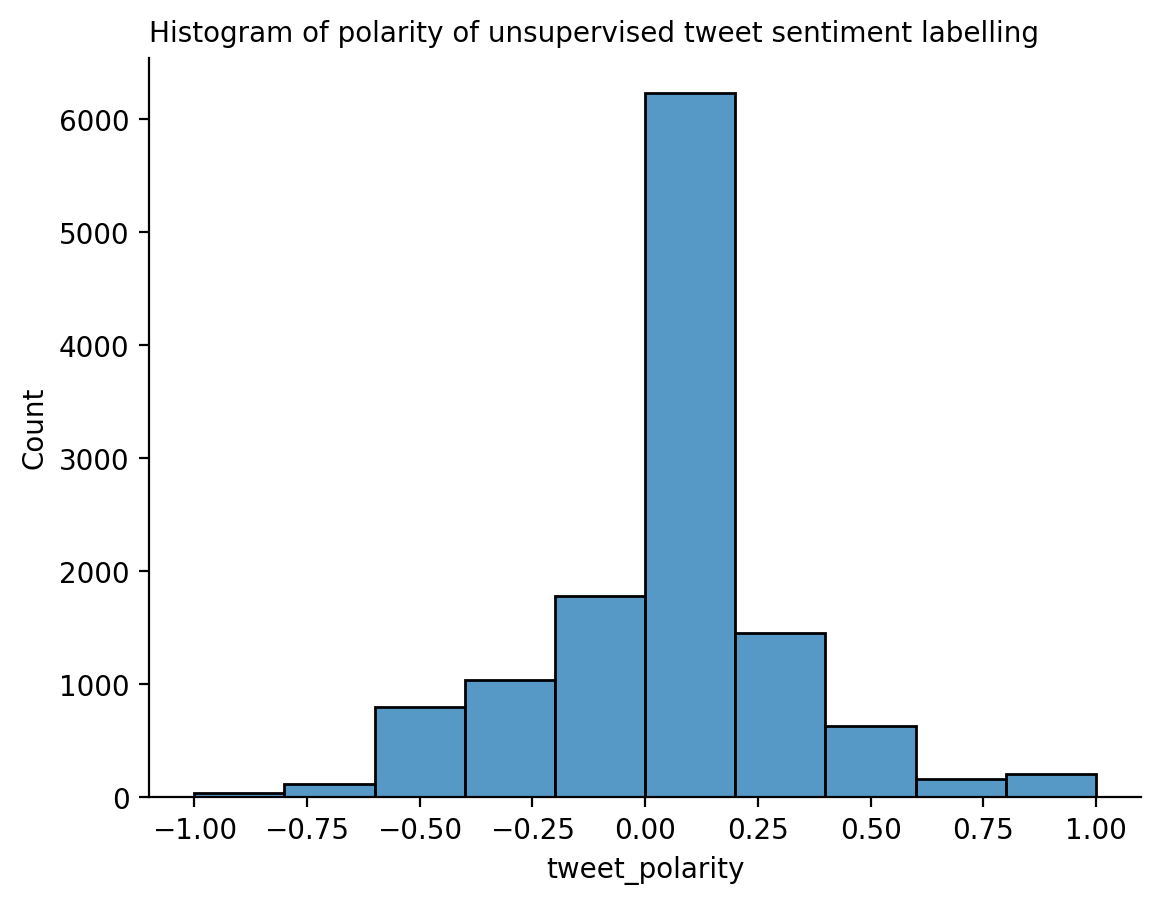

In [234]:
# Check distribution of tweet polarity
sns.histplot(data=tweets, x="tweet_polarity", bins=10)
plt.title("Histogram of polarity of unsupervised tweet sentiment labelling", fontsize=10, loc="left")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [7]:
# Split the tweets by sentiments
def assign_sentiment(tweet_polarity):
    if tweet_polarity < 0:
        return -1
    elif tweet_polarity > 0.09:
        return 1
    else:
        return 0

# Assign the sentiment based on polarity
tweets["sentiment"] = tweets.apply(lambda x: assign_sentiment(x["tweet_polarity"]), axis=1)

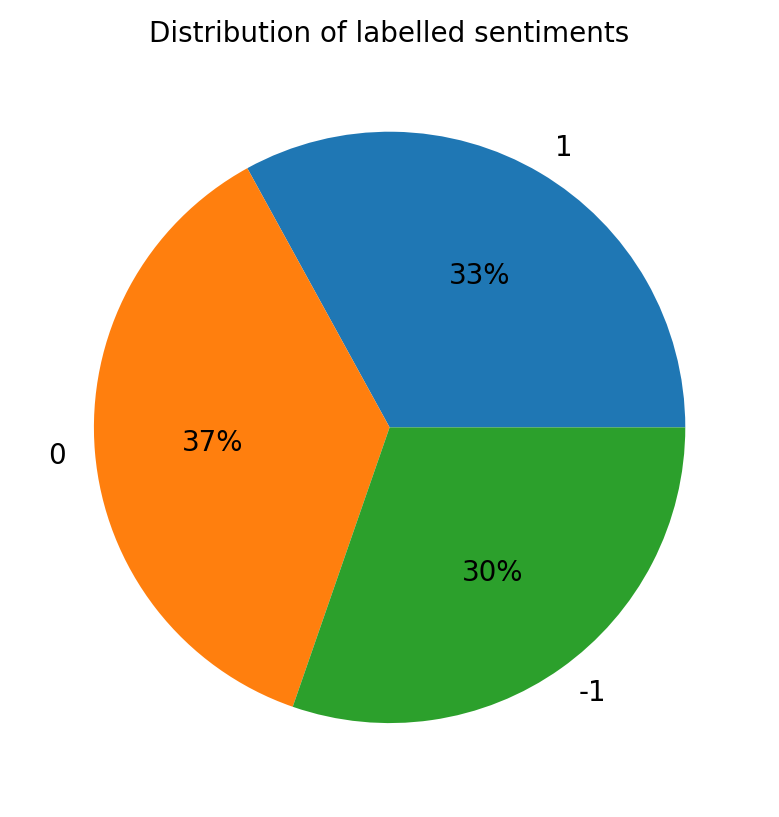

In [223]:
# Visualize the distribution of labelled tweet sentiments
sentiment_dist = tweets.value_counts("sentiment").sort_index(ascending=False).reset_index()
plt.pie(sentiment_dist[0], labels=sentiment_dist["sentiment"], autopct="%.0f%%")
plt.title("Distribution of labelled sentiments", fontsize=10)
plt.show()

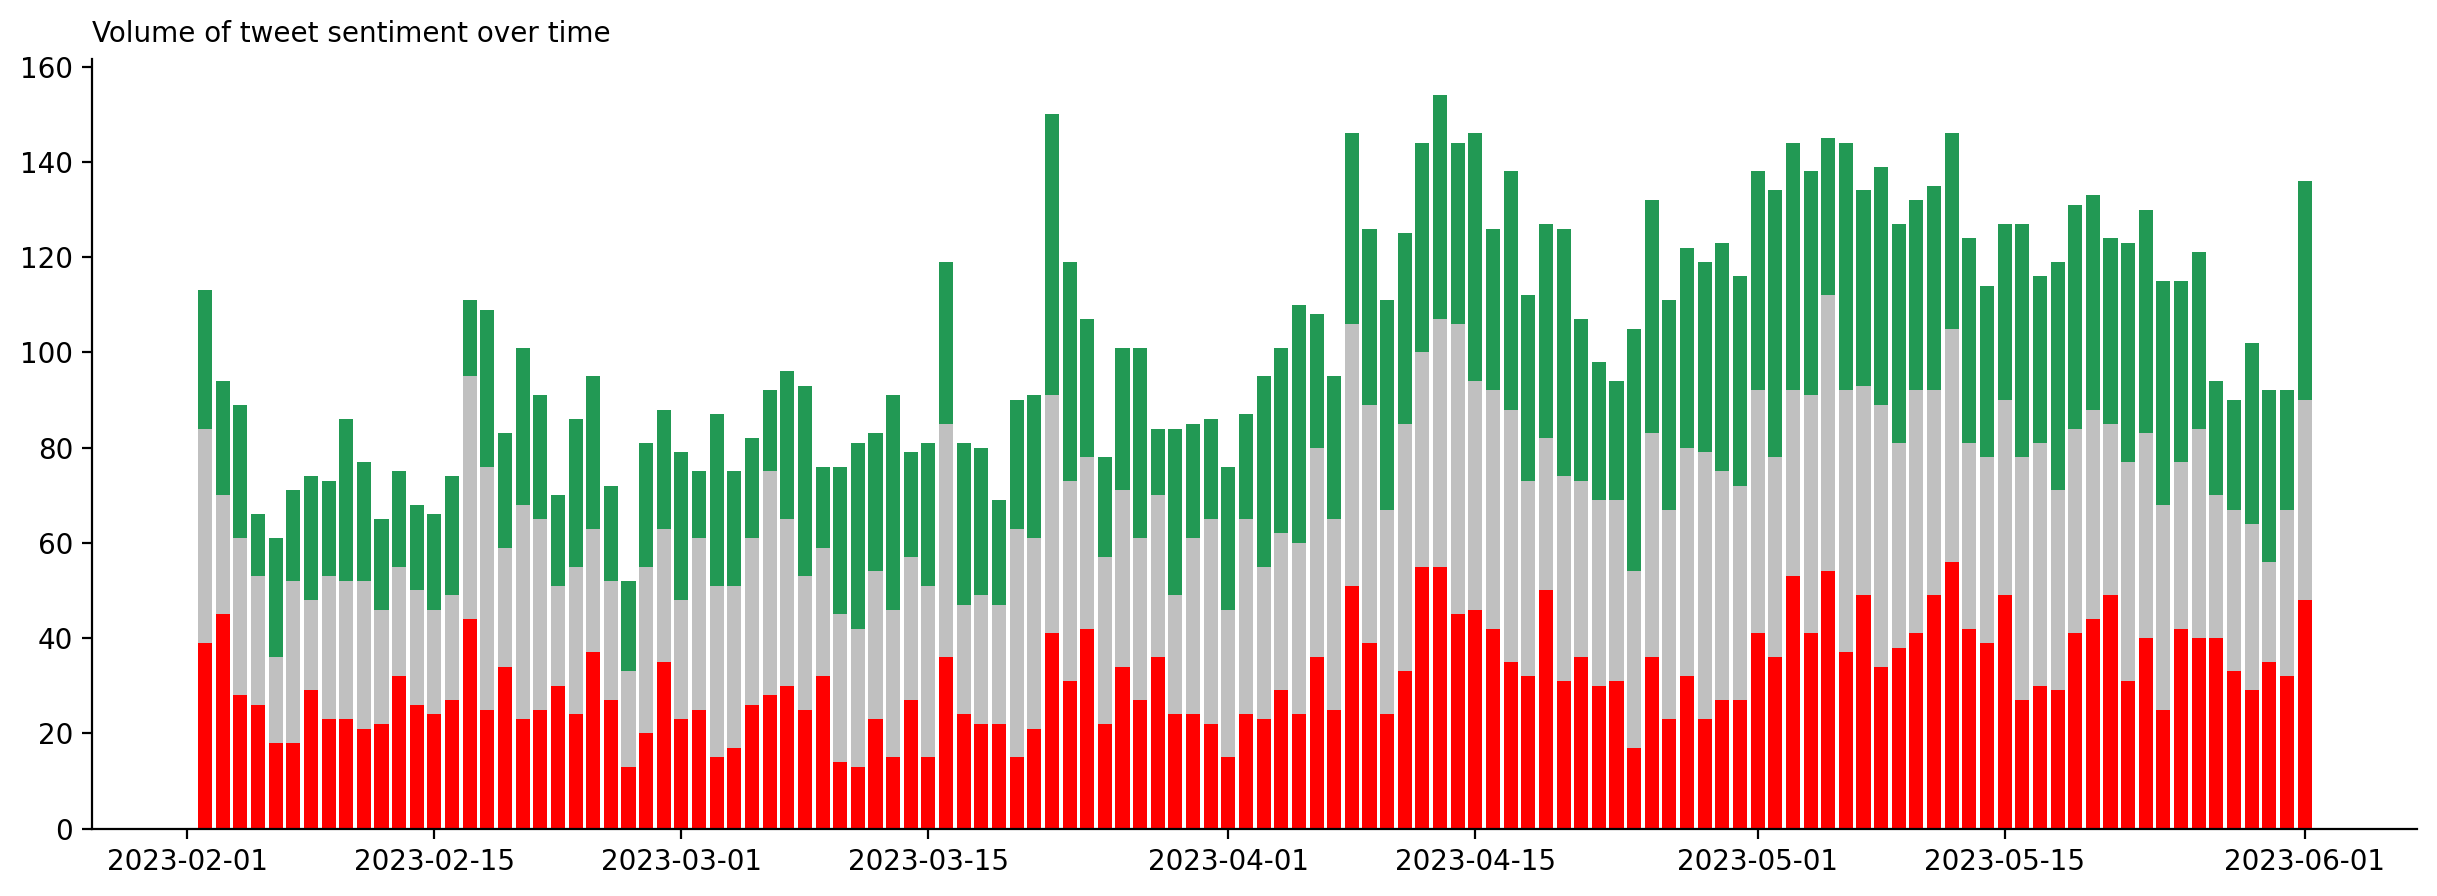

In [235]:
# Visualize tweet sentiment over time
tweet_time = pd.pivot_table(tweets, index=["date"], columns="sentiment", values="tweet_clean", aggfunc="count")

tweet_time["-1_pc"] = tweet_time[-1] / tweet_time[[-1, 0, 1]].sum(axis=1)
tweet_time["0_pc"] = tweet_time[0] / tweet_time[[-1, 0, 1]].sum(axis=1)
tweet_time["1_pc"] = tweet_time[1] / tweet_time[[-1, 0, 1]].sum(axis=1)

plt.figure(figsize=(15, 5))
plt.bar(x=tweet_time.index, height=tweet_time[-1], color="red")
plt.bar(x=tweet_time.index, height=tweet_time[0], bottom=tweet_time[-1], color="silver")
plt.bar(x=tweet_time.index, height=tweet_time[1], bottom=tweet_time[-1] + tweet_time[0], color="#229954")
plt.title("Volume of tweet sentiment over time", fontsize=10, loc="left")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

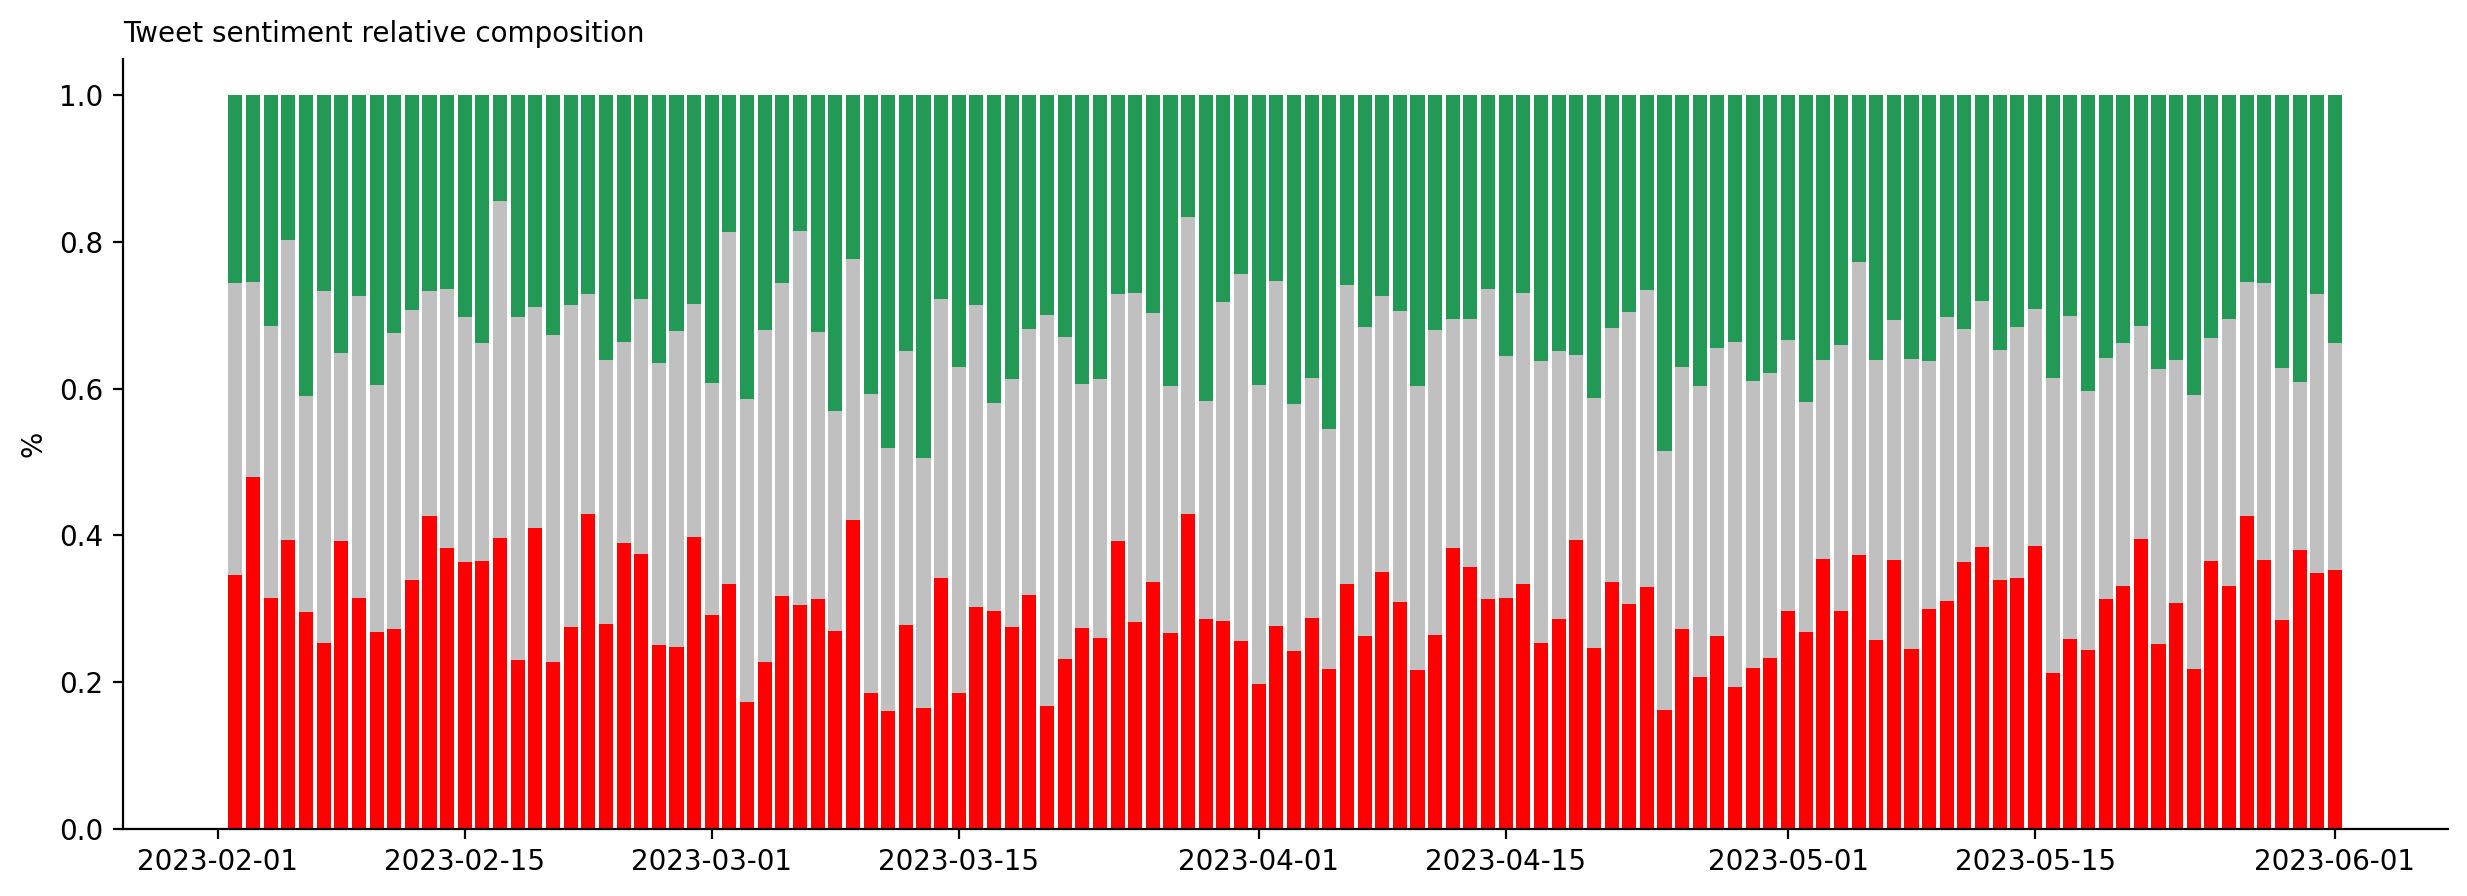

In [236]:
# Plot the chart by daily relative composition of sentiments
plt.figure(figsize=(15, 5))
plt.bar(x=tweet_time.index, height=tweet_time["-1_pc"], color="red")
plt.bar(x=tweet_time.index, height=tweet_time["0_pc"], bottom=tweet_time["-1_pc"], color="silver")
plt.bar(x=tweet_time.index, height=tweet_time["1_pc"], bottom=tweet_time["-1_pc"] + tweet_time["0_pc"], color="#229954")
plt.ylabel("%")
plt.title("Tweet sentiment relative composition", fontsize=10, loc="left")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

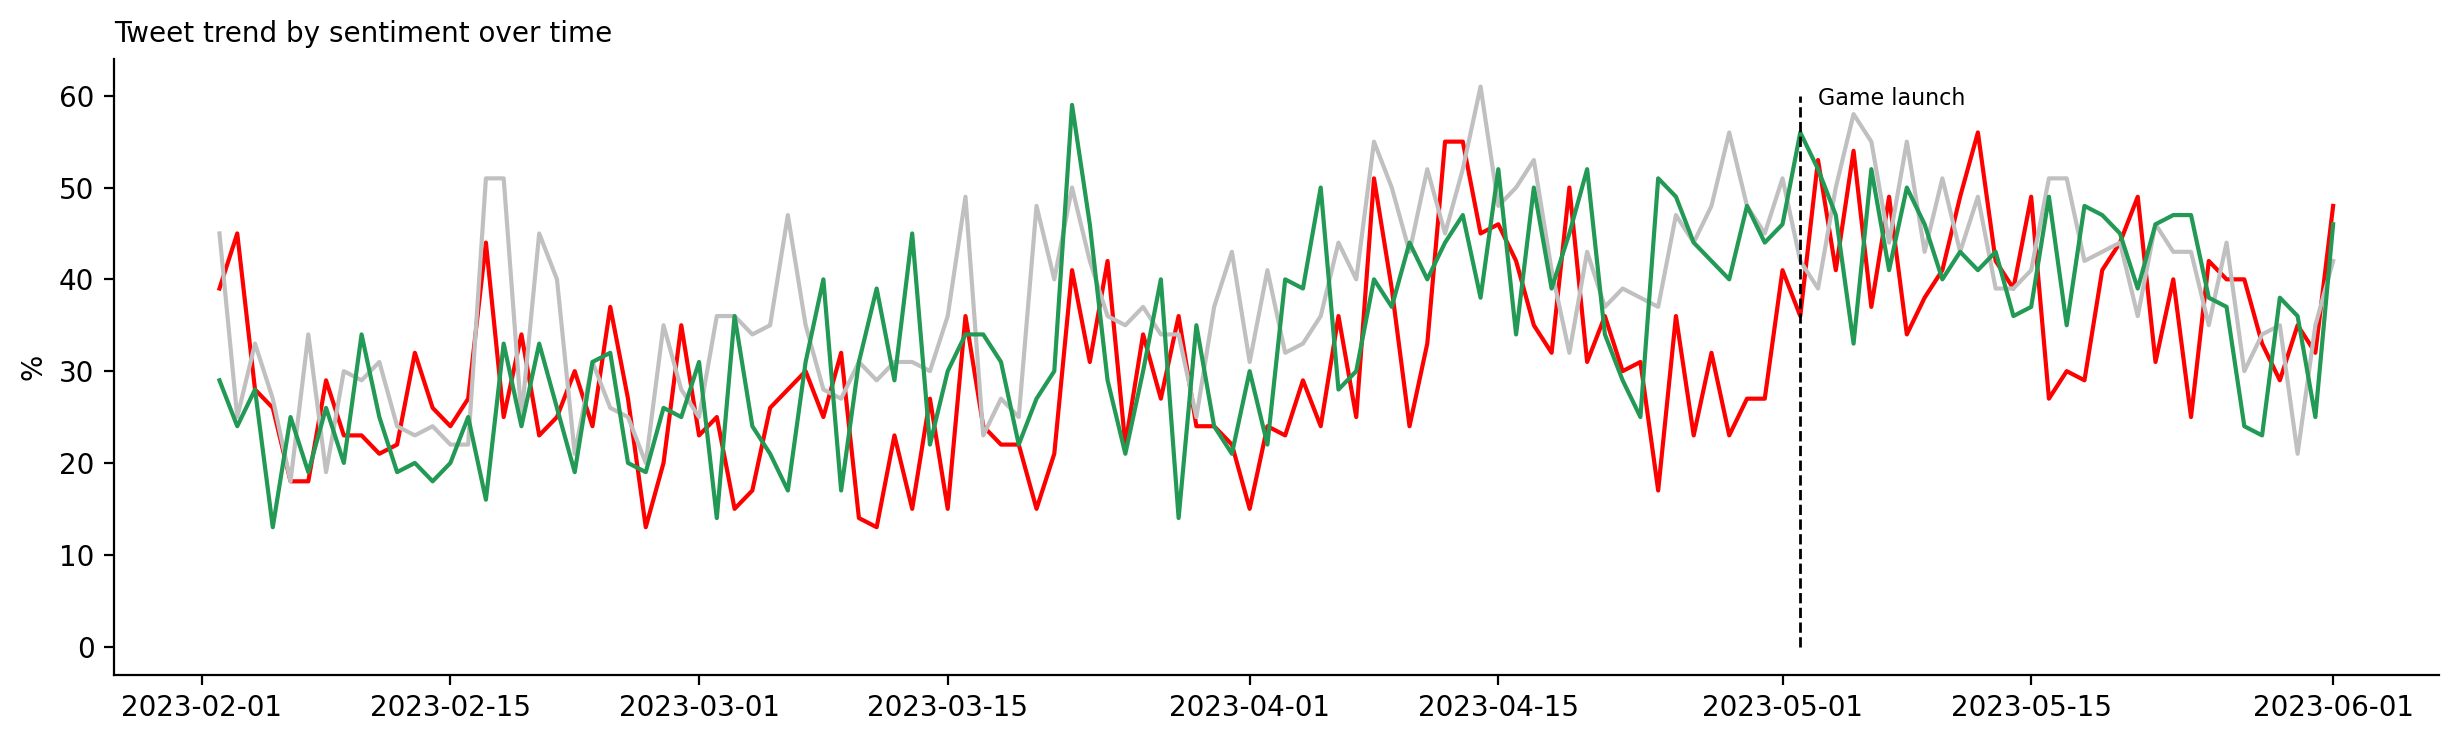

In [248]:
# Visualize as time series by sentiment
plt.figure(figsize=(15, 4))
sns.lineplot(data=tweet_time, x="date", y=tweet_time[-1], color="red")
sns.lineplot(data=tweet_time, x="date", y=tweet_time[0], color="silver")
sns.lineplot(data=tweet_time, x="date", y=tweet_time[1], color="#229954")
plt.vlines(ymax=60, ymin=0, x=dt.datetime(2023, 5, 2), linestyles="--", color="black", linewidth=1)
plt.ylabel("%")
plt.title("Tweet trend by sentiment over time", fontsize=10, loc="left")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("")
plt.text(dt.datetime(2023,5,3), 59, "Game launch", fontsize=8)
plt.show()

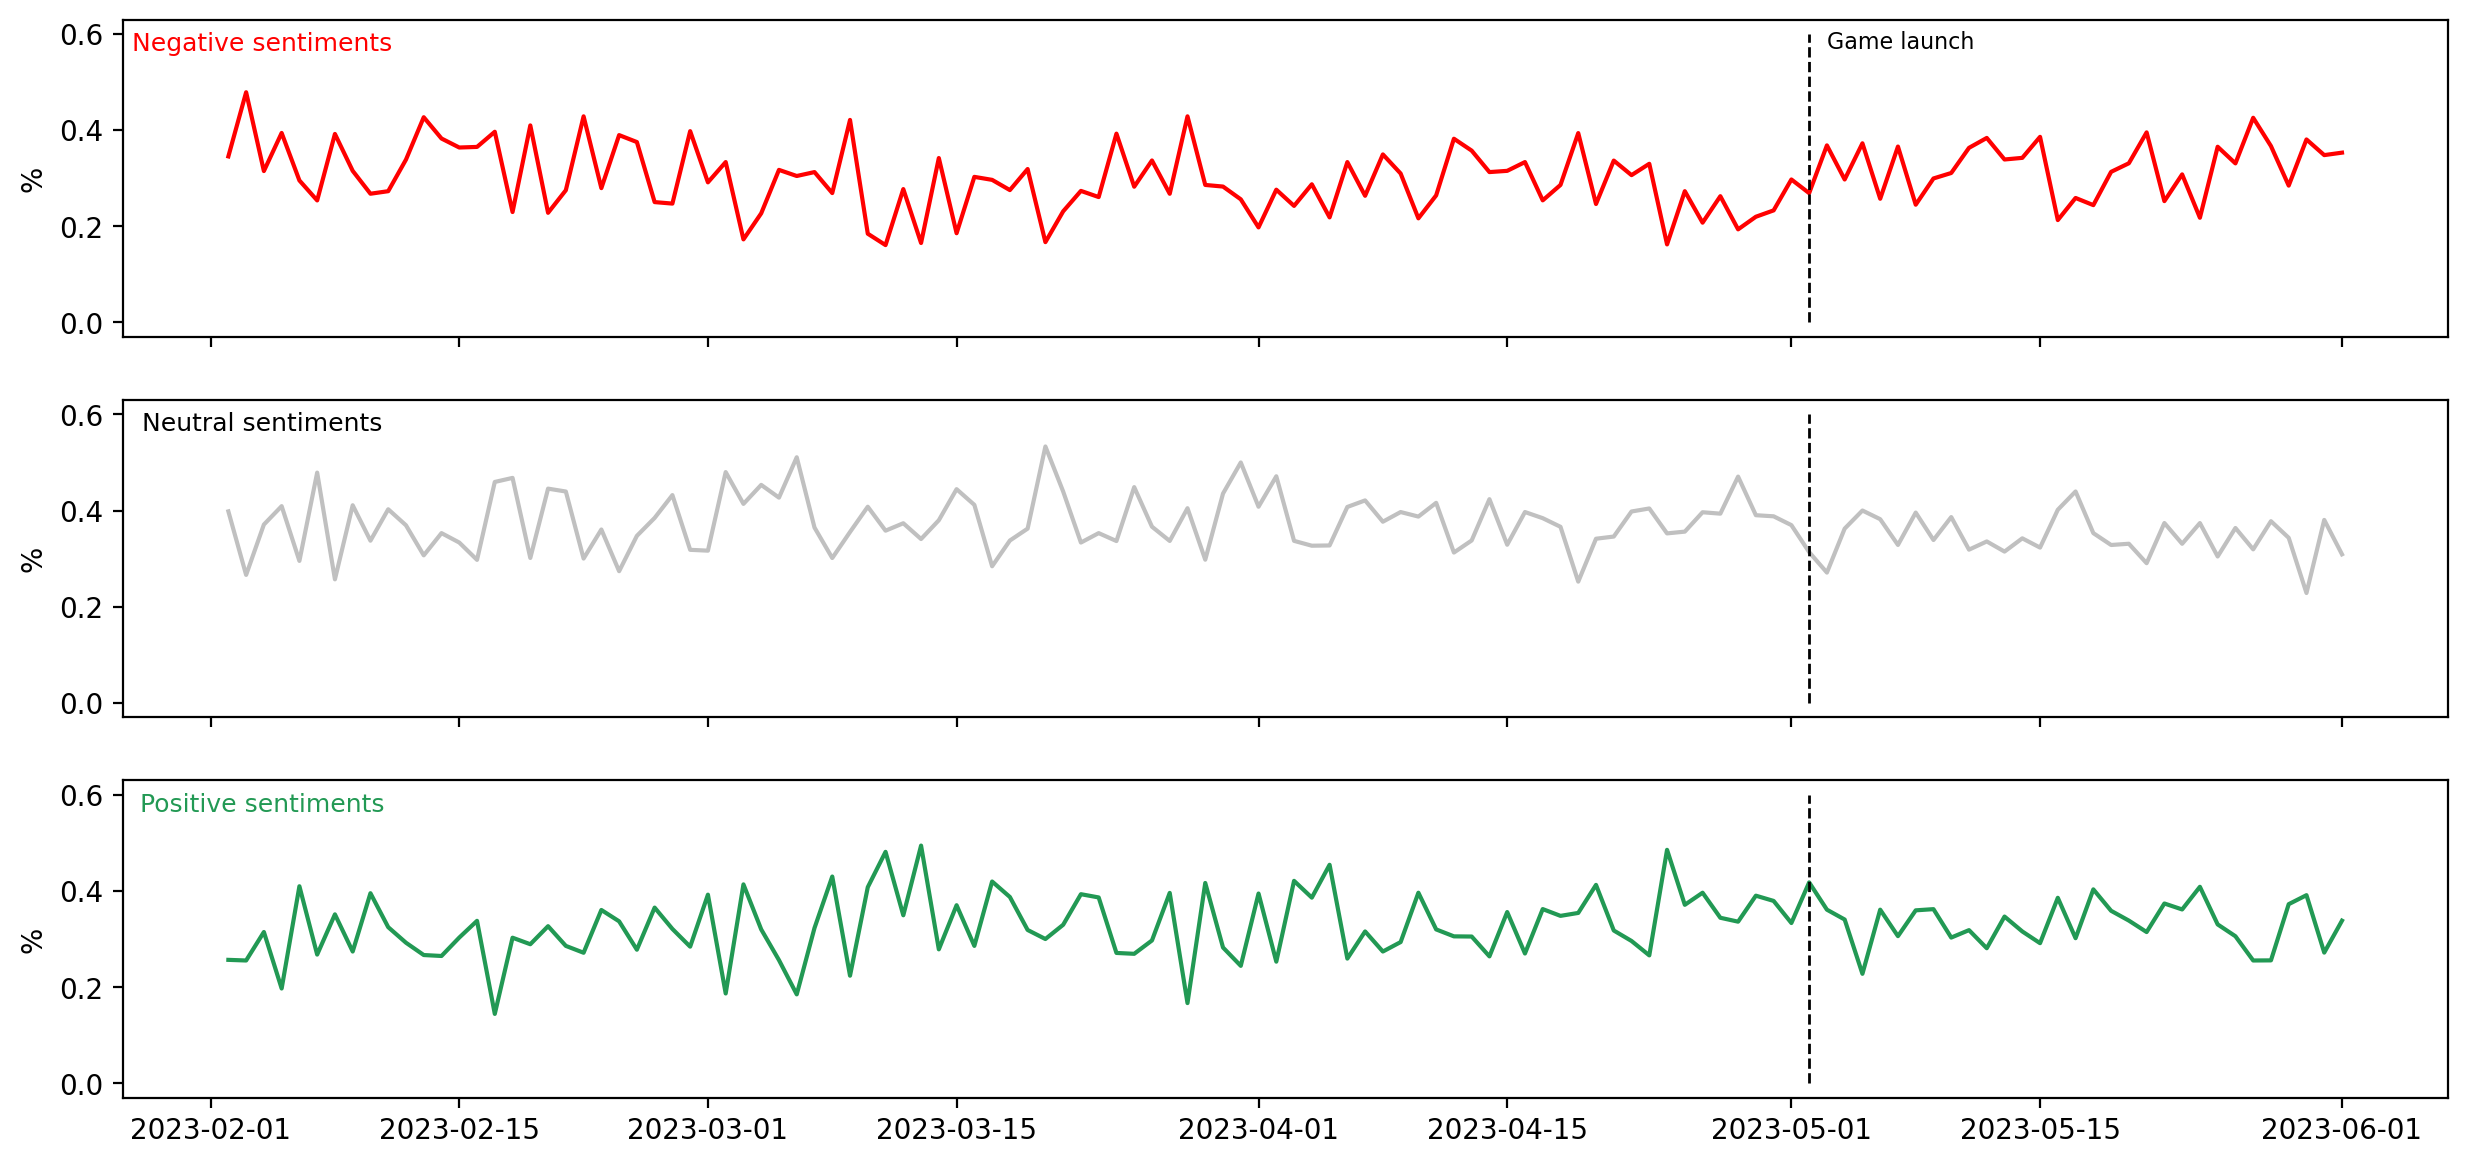

In [253]:
# Visualize as time series by daily relative composition of tweets by sentiment
fig, ax = plt.subplots(3, 1, figsize=(15, 7), sharey=True, sharex=True)
sns.lineplot(data=tweet_time, x="date", y=tweet_time["-1_pc"], color="red", ax=ax[0])
ax[0].set_title("Negative sentiments", fontsize=9, x=0.06, y=0.85, color="red")
sns.lineplot(data=tweet_time, x="date", y=tweet_time["0_pc"], color="silver", ax=ax[1])
ax[1].set_title("Neutral sentiments", fontsize=9, x=0.06, y=0.85)
sns.lineplot(data=tweet_time, x="date", y=tweet_time["1_pc"], color="#229954", ax=ax[2])
ax[2].set_title("Positive sentiments", fontsize=9, x=0.06, y=0.85, color="#229954")
ax[0].vlines(ymax=0.6, ymin=0, x=dt.datetime(2023, 5, 2), linestyles="--", color="black", linewidth=1)
ax[1].vlines(ymax=0.6, ymin=0, x=dt.datetime(2023, 5, 2), linestyles="--", color="black", linewidth=1)
ax[2].vlines(ymax=0.6, ymin=0, x=dt.datetime(2023, 5, 2), linestyles="--", color="black", linewidth=1)
ax[0].set_ylabel("%")
ax[1].set_ylabel("%")
ax[2].set_ylabel("%")
ax[2].set_xlabel("")
ax[0].text(dt.datetime(2023, 5, 3), 0.57, "Game launch", fontsize=8)
plt.show()

In [189]:
# Fit linear model for negative sentiment before launch date
neg_bef = tweet_time.loc[dt.datetime(2023, 4, 1):dt.datetime(2023, 5, 2), "-1_pc"].reset_index()

# Fit linear regression model
x = np.arange(32)
y = neg_bef["-1_pc"].values

X = sm.add_constant(x)
neg_bef_lm = sm.OLS(y, X)
neg_bef_results = neg_bef_lm.fit()
neg_bef_predict = neg_bef_results.predict(X)

# Construct dataframe to store the predictions
neg_bef = pd.DataFrame(neg_bef_predict, columns=["predicted_negative_sentiments"])
neg_bef = pd.concat([pd.DataFrame(pd.date_range(dt.datetime(2023, 4, 1), dt.datetime(2023, 5, 2)), columns=["date"]), neg_bef], axis=1)

In [192]:
# Fit linear model for negative sentiment after launch date
neg_aft = tweet_time.loc[dt.datetime(2023, 5, 2):dt.datetime(2023, 6, 1), "-1_pc"].reset_index()

# Fit linear regression model
x = np.arange(31)
y = neg_aft["-1_pc"].values

X = sm.add_constant(x)
neg_aft_lm = sm.OLS(y, X)
neg_aft_results = neg_aft_lm.fit()
neg_aft_predict = neg_aft_results.predict(X)

# Construct dataframe to store the predictions
neg_aft = pd.DataFrame(neg_aft_predict, columns=["predicted_negative_sentiments"])
neg_aft = pd.concat([pd.DataFrame(pd.date_range(dt.datetime(2023, 5, 2), dt.datetime(2023, 6, 1)), columns=["date"]), neg_aft], axis=1)

In [209]:
# Fit linear model for positive sentiment before launch date
pos_bef = tweet_time.loc[dt.datetime(2023, 4, 1):dt.datetime(2023, 5, 2), "1_pc"].reset_index()

# Fit linear regression model
x = np.arange(32)
y = pos_bef["1_pc"].values

X = sm.add_constant(x)
pos_bef_lm = sm.OLS(y, X)
pos_bef_results = pos_bef_lm.fit()
pos_bef_predict = pos_bef_results.predict(X)

# Construct dataframe to store the predictions
pos_bef = pd.DataFrame(pos_bef_predict, columns=["predicted_negative_sentiments"])
pos_bef = pd.concat([pd.DataFrame(pd.date_range(dt.datetime(2023, 4, 1), dt.datetime(2023, 5, 1)), columns=["date"]), pos_bef], axis=1)

In [203]:
# Fit linear model for positive sentiment after launch date
pos_aft = tweet_time.loc[dt.datetime(2023, 5, 2):dt.datetime(2023, 6, 1), "1_pc"].reset_index()

# Fit linear regression model
x = np.arange(31)
y = pos_aft["1_pc"].values

X = sm.add_constant(x)
pos_aft_lm = sm.OLS(y, X)
pos_aft_results = pos_aft_lm.fit()
pos_aft_predict = pos_aft_results.predict(X)

# Construct dataframe to store the predictions
pos_aft = pd.DataFrame(pos_aft_predict, columns=["predicted_negative_sentiments"])
pos_aft = pd.concat([pd.DataFrame(pd.date_range(dt.datetime(2023, 5, 2), dt.datetime(2023, 6, 1)), columns=["date"]), pos_aft], axis=1)

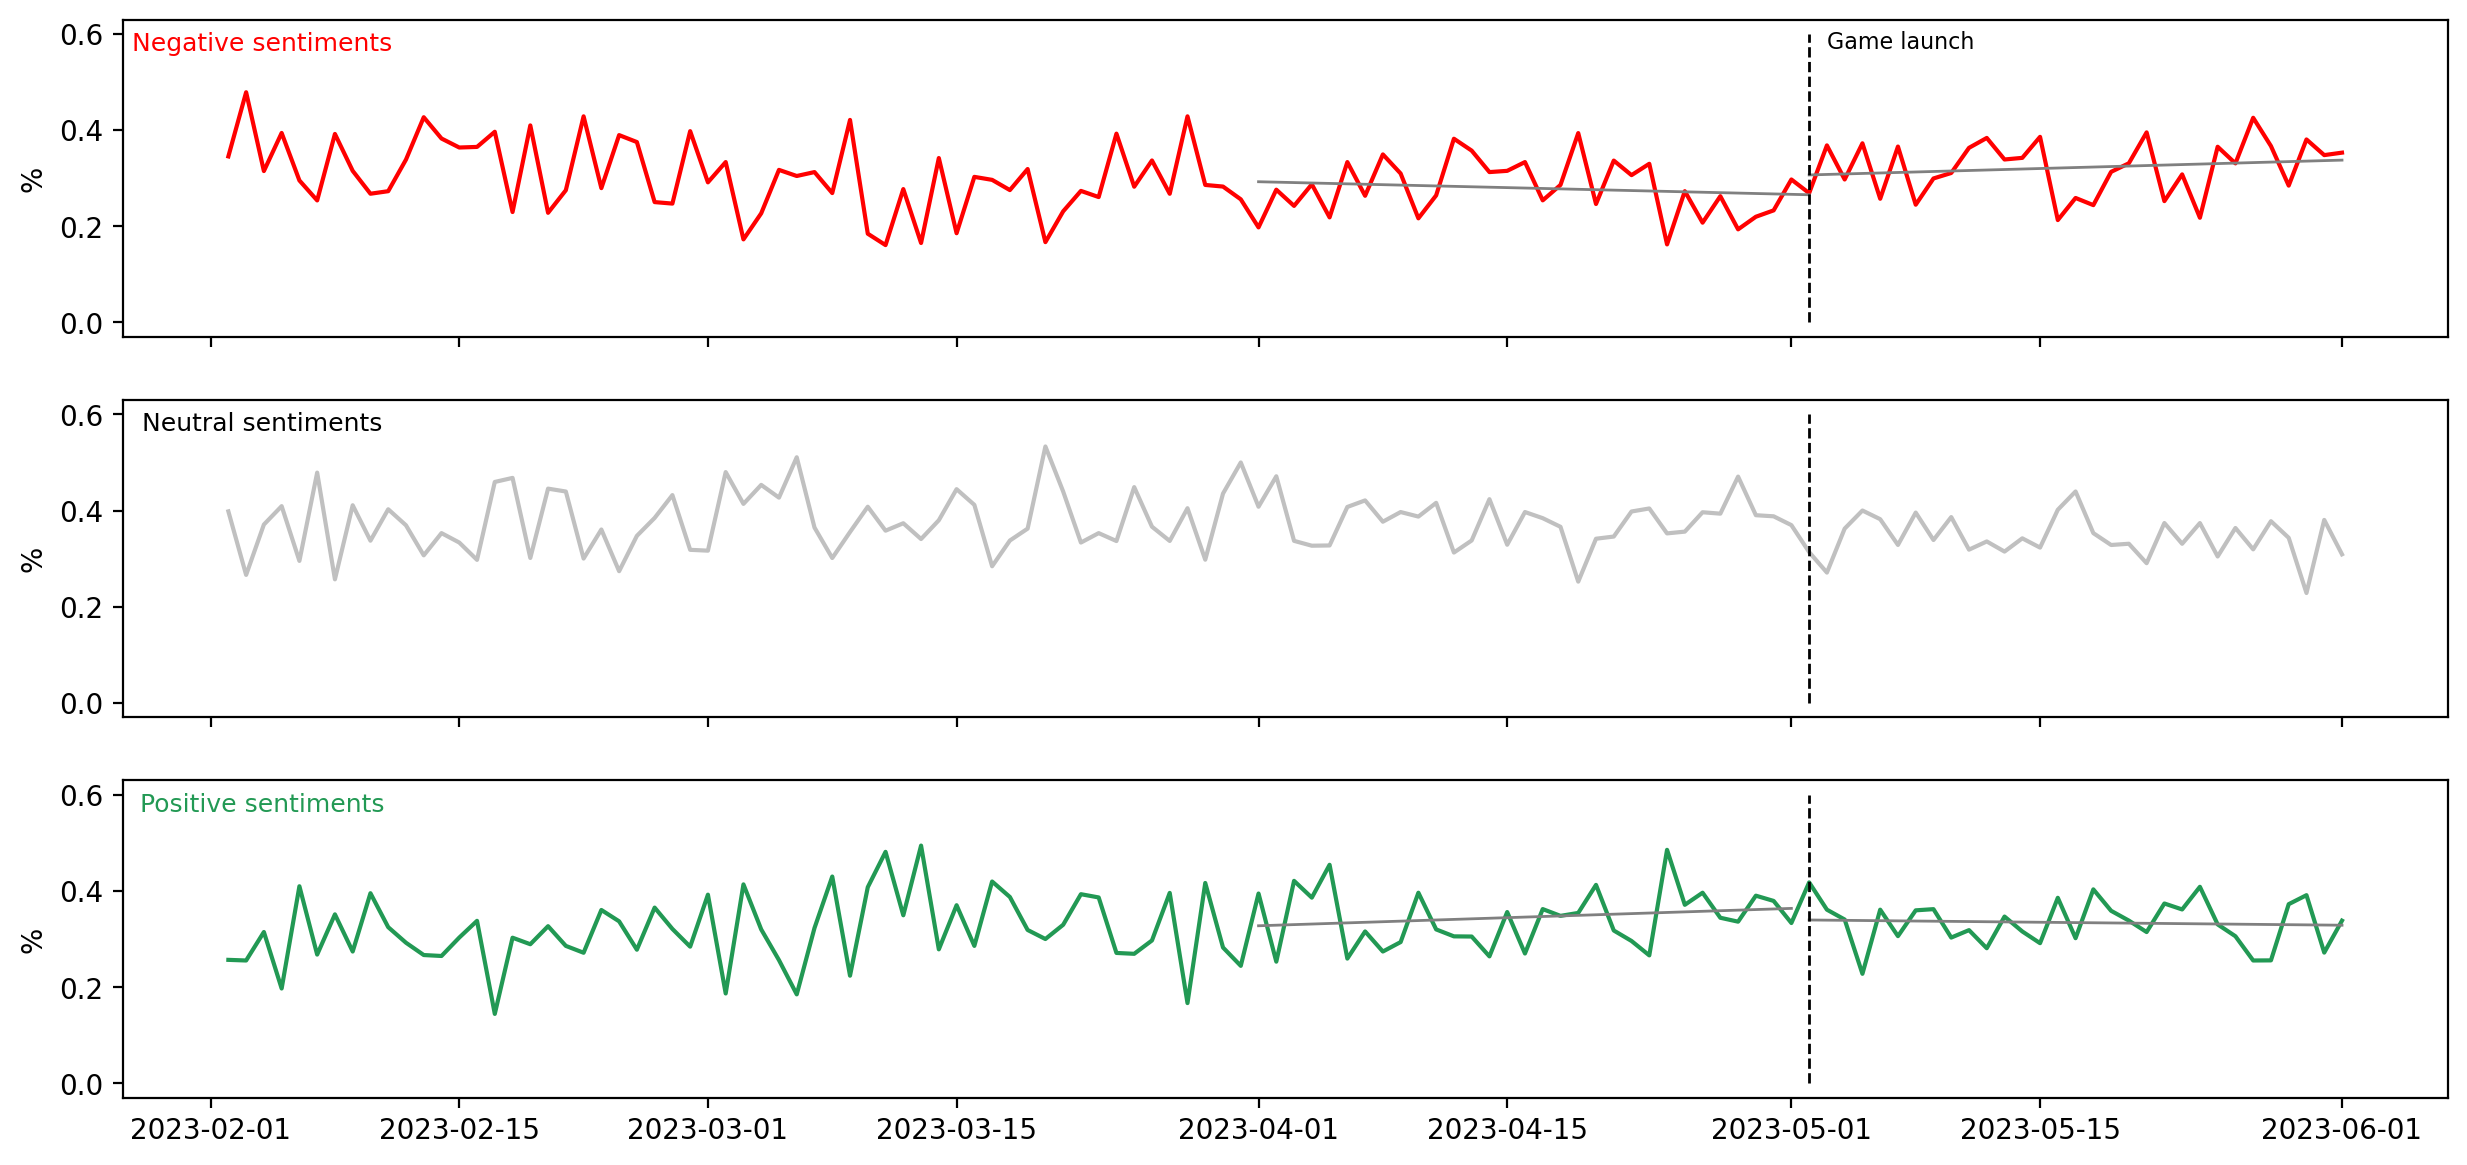

In [255]:
# Visualize as time series by sentiment, overlay with linear models to see trend direction
fig, ax = plt.subplots(3, 1, figsize=(15, 7), sharey=True, sharex=True)
sns.lineplot(data=tweet_time, x="date", y=tweet_time["-1_pc"], color="red", ax=ax[0])
ax[0].set_title("Negative sentiments", fontsize=9, x=0.06, y=0.85, color="red")
sns.lineplot(data=neg_bef, x="date", y="predicted_negative_sentiments", linewidth=1, color="grey", ax=ax[0])
sns.lineplot(data=neg_aft, x="date", y="predicted_negative_sentiments", linewidth=1, color="grey", ax=ax[0])
sns.lineplot(data=tweet_time, x="date", y=tweet_time["0_pc"], color="silver", ax=ax[1])
ax[1].set_title("Neutral sentiments", fontsize=9, x=0.06, y=0.85)
sns.lineplot(data=tweet_time, x="date", y=tweet_time["1_pc"], color="#229954", ax=ax[2])
sns.lineplot(data=pos_bef, x="date", y="predicted_negative_sentiments", linewidth=1, color="grey", ax=ax[2])
sns.lineplot(data=pos_aft, x="date", y="predicted_negative_sentiments", linewidth=1, color="grey", ax=ax[2])
ax[2].set_title("Positive sentiments", fontsize=9, x=0.06, y=0.85, color="#229954")
ax[0].vlines(ymax=0.6, ymin=0, x=dt.datetime(2023, 5, 2), linestyles="--", color="black", linewidth=1)
ax[1].vlines(ymax=0.6, ymin=0, x=dt.datetime(2023, 5, 2), linestyles="--", color="black", linewidth=1)
ax[2].vlines(ymax=0.6, ymin=0, x=dt.datetime(2023, 5, 2), linestyles="--", color="black", linewidth=1)
ax[0].set_ylabel("%")
ax[1].set_ylabel("%")
ax[2].set_ylabel("%")
ax[2].set_xlabel("")
ax[0].text(dt.datetime(2023, 5, 3), 0.57, "Game launch", fontsize=8)
plt.show()

In [14]:
# Find most frequent positive words
pos_tweets = tweets[tweets["sentiment"] == 1]
neg_tweets = tweets[tweets["sentiment"] == 0]

In [214]:
# Get word freq dictionary
pos_tweets_list = []
pos_words_freq = {}
for tweet in pos_tweets["tweet_clean"]:
    for word in tweet:
        pos_words_freq[word] = pos_words_freq.get(word, 0) + 1

pos_top50 = sorted(pos_words_freq.items(), key=lambda x: x[1], reverse=True)[0:50]

neg_tweets_list = []
neg_words_freq = {}
for tweet in neg_tweets["tweet_clean"]:
    for word in tweet:
        neg_words_freq[word] = neg_words_freq.get(word, 0) + 1

neg_top50 = sorted(neg_words_freq.items(), key=lambda x: x[1], reverse=True)[0:50]

# Combine the word freq
neg_top50 = pd.DataFrame(neg_top50).rename(columns={0: "word", 1: "freq_neg"})
pos_top50 = pd.DataFrame(pos_top50).rename(columns={0: "word", 1: "freq_pos"})
top_words = pd.merge(left=neg_top50, right=pos_top50, on="word", how="inner")
top_words["total_freq"] = top_words[["freq_neg", "freq_pos"]].sum(axis=1)

# Reorder top words
top_words.sort_values("total_freq", ascending=False, inplace=True)
top_words.reset_index(inplace=True, drop=True)
top_words10 = top_words.loc[0:10, :]
top_words10["log_freq_neg"] = np.log(top_words["freq_neg"])
top_words10["log_freq_pos"] = np.log(top_words["freq_pos"])

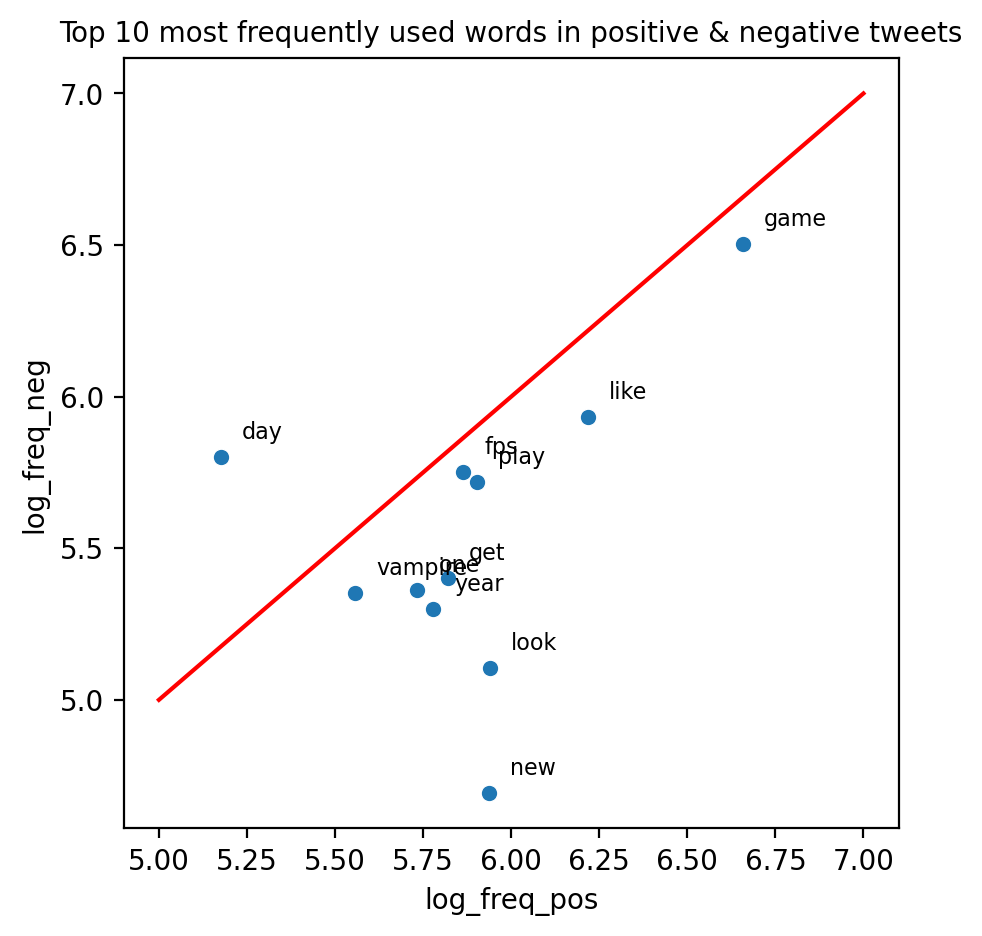

In [257]:
# Visualize top words
plt.figure(figsize=(5, 5))
sns.scatterplot(data=top_words10, x="log_freq_pos", y="log_freq_neg")
for row in top_words10.iterrows():
    plt.text(s=row[1][0], x=row[1][5] + 0.06, y=row[1][4] + 0.06, fontsize=8)
sns.lineplot(x=[5,6,7], y=[5,6,7], linewidth=1.5, color="red")
plt.title("Top 10 most frequently used words in positive & negative tweets", fontsize=10)
plt.show()

### Word embedding - document text matrix (DTM)

In [17]:
label = tweets["sentiment"]
sentences = tweets["tweet_clean"].to_list()

In [18]:
# Setup the model
cv = CountVectorizer(analyzer=lambda x: x)
word_freq = cv.fit_transform(sentences)

tf = TfidfVectorizer(analyzer=lambda x: x)
tfidf = tf.fit_transform(sentences)

## Count Vectorizer DTM

### KNN Clustering

In [25]:
# Implement K-Folds, use classification accuracy as scoring metric
k_folds = 10
knn_cnt_vec_results = []

for k in range(2, k_folds + 1):

    # Initialize kfolds
    kf = KFold(n_splits=k, shuffle=True)

    k_fold_results = []

    # Split the dataset into train / test by k-fold index
    for (train_index, test_index) in kf.split(word_freq.toarray()):
        x_train = word_freq.toarray()[train_index]
        x_test = word_freq.toarray()[test_index]
        y_train = label[train_index]
        y_test = label[test_index]

        # Initialize KNN model - 3 neighbors only
        knn = KNeighborsClassifier(n_neighbors=3)

        # Train KNN model with 3 neighbors
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)

        k_fold_results.append(accuracy_score(y_test, y_pred))
    knn_cnt_vec_results.append((k, np.mean(k_fold_results)))

In [26]:
# KNN CV results
knn_cnt_vec_results

[(2, 0.5464817463590796),
 (3, 0.558994945230669),
 (4, 0.5620440703039318),
 (5, 0.5691819050036171),
 (6, 0.5735952792157071),
 (7, 0.567738830512553),
 (8, 0.5747975336383795),
 (9, 0.5758388422648352),
 (10, 0.5765632059478865)]

### Decision Tree Classifier

In [29]:
# Implement K-Folds, use classification accuracy as scoring metric
k_folds = 10
dt_cnt_vec_results = []

for k in range(2, k_folds + 1):

    # Initialize kfolds
    kf = KFold(n_splits=k, shuffle=True)

    k_fold_results = []

    # Split the dataset into train / test by k-fold index
    for (train_index, test_index) in kf.split(word_freq.toarray()):
        x_train = word_freq.toarray()[train_index]
        x_test = word_freq.toarray()[test_index]
        y_train = label[train_index]
        y_test = label[test_index]

        # Initialize model
        dt = DecisionTreeClassifier()

        # Train KNN model with 3 neighbors
        dt.fit(x_train, y_train)
        y_pred = dt.predict(x_test)

        k_fold_results.append(accuracy_score(y_test, y_pred))
    dt_cnt_vec_results.append((k, np.mean(k_fold_results)))

In [30]:
# Decision tree CV results
dt_cnt_vec_results

[(2, 0.802357555315939),
 (3, 0.8227324284705548),
 (4, 0.8314751746499279),
 (5, 0.8340412014908786),
 (6, 0.835326032138664),
 (7, 0.8354054704419668),
 (8, 0.8369303337035936),
 (9, 0.8377312752764017),
 (10, 0.8349248469199273)]

#### Random Forest Classification (Bagging)

In [31]:
# Implement K-Folds, use classification accuracy as scoring metric
k_folds = 10
rf_cnt_vec_results = []

for k in range(2, k_folds + 1):

    # Initialize kfolds
    kf = KFold(n_splits=k, shuffle=True)

    k_fold_results = []

    # Split the dataset into train / test by k-fold index
    for (train_index, test_index) in kf.split(word_freq.toarray()):
        x_train = word_freq.toarray()[train_index]
        x_test = word_freq.toarray()[test_index]
        y_train = label[train_index]
        y_test = label[test_index]

        # Initialize model
        rf = RandomForestClassifier()

        # Train KNN model with 3 neighbors
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)

        k_fold_results.append(accuracy_score(y_test, y_pred))
    rf_cnt_vec_results.append((k, np.mean(k_fold_results)))

In [32]:
# Random forest CV results
rf_cnt_vec_results

[(2, 0.8137484487160225),
 (3, 0.8285869153552952),
 (4, 0.8339616427039099),
 (5, 0.832117354414333),
 (6, 0.8358869674107651),
 (7, 0.8376513996951954),
 (8, 0.8385324333181551),
 (9, 0.8389347604750734),
 (10, 0.8433463426187536)]

#### SVM (Linear SVC)

In [33]:
# Implement K-Folds, use classification accuracy as scoring metric
k_folds = 10
svc_cnt_vec_results = []

for k in range(2, k_folds + 1):

    # Initialize kfolds
    kf = KFold(n_splits=k, shuffle=True)

    k_fold_results = []

    # Split the dataset into train / test by k-fold index
    for (train_index, test_index) in kf.split(word_freq.toarray()):
        x_train = word_freq.toarray()[train_index]
        x_test = word_freq.toarray()[test_index]
        y_train = label[train_index]
        y_test = label[test_index]

        # Initialize model
        svc = LinearSVC()

        # Train KNN model with 3 neighbors
        svc.fit(x_train, y_train)
        y_pred = svc.predict(x_test)

        k_fold_results.append(accuracy_score(y_test, y_pred))
    svc_cnt_vec_results.append((k, np.mean(k_fold_results)))

In [34]:
# Linear SVC CV results
svc_cnt_vec_results

[(2, 0.7916099001346544),
 (3, 0.8150317520433538),
 (4, 0.8194435006504971),
 (5, 0.8239357611094545),
 (6, 0.8252181916954395),
 (7, 0.8287478944413251),
 (8, 0.8314761136833542),
 (9, 0.8303525195221946),
 (10, 0.8310738066705197)]

### Naive Bayes

In [38]:
# Implement K-Folds, use classification accuracy as scoring metric
k_folds = 10
nb_cnt_vec_results = []

for k in range(2, k_folds + 1):

    # Initialize kfolds
    kf = KFold(n_splits=k, shuffle=True)

    k_fold_results = []

    # Split the dataset into train / test by k-fold index
    for (train_index, test_index) in kf.split(word_freq.toarray()):
        x_train = word_freq.toarray()[train_index]
        x_test = word_freq.toarray()[test_index]
        y_train = label[train_index]
        y_test = label[test_index]

        # Initialize model
        nb = MultinomialNB()

        # Train KNN model with 3 neighbors
        nb.fit(x_train, y_train)
        y_pred = nb.predict(x_test)

        k_fold_results.append(accuracy_score(y_test, y_pred))
    nb_cnt_vec_results.append((k, np.mean(k_fold_results)))

In [39]:
# Naive-Bayes CV results
nb_cnt_vec_results

[(2, 0.663913010536558),
 (3, 0.6777891281343296),
 (4, 0.6845257620741447),
 (5, 0.6861289236164387),
 (6, 0.6827632615277488),
 (7, 0.6900617630544638),
 (8, 0.6869314350152043),
 (9, 0.6911850150117299),
 (10, 0.6898208348511549)]

#### Consolidate results

In [50]:
# KNN
knn_score_new = []
for knn in knn_cnt_vec_results:
    knn2 = ("knn",) + knn
    knn_score_new.append(knn2)

# Decision tree
dt_score_new = []
for dt in dt_cnt_vec_results:
    dt2 = ("decision_tree",) + dt
    dt_score_new.append(dt2)

# Random forest
rf_score_new = []
for rf in rf_cnt_vec_results:
    rf2 = ("random_forest",) + rf
    rf_score_new.append(rf2)

# SVM classifier
svc_score_new = []
for svc in svc_cnt_vec_results:
    svc2 = ("linear_svc",) + svc
    svc_score_new.append(svc2)

# Naive Bayes
nb_score_new = []
for nb in nb_cnt_vec_results:
    nb2 = ("naive_bayes",) + nb
    nb_score_new.append(nb2)

# Construct dataframe to store the results
knn = pd.DataFrame(knn_score_new)
dt = pd.DataFrame(dt_score_new)
rf = pd.DataFrame(rf_score_new)
svc = pd.DataFrame(svc_score_new)
nb = pd.DataFrame(nb_score_new)
all_models = pd.concat([knn, dt, rf, svc, nb], axis=0)
all_models.columns = ["model", "k_fold", "acc_score"]

all_models["log_acc_score"] = np.log(all_models["acc_score"])

#### Visualize results

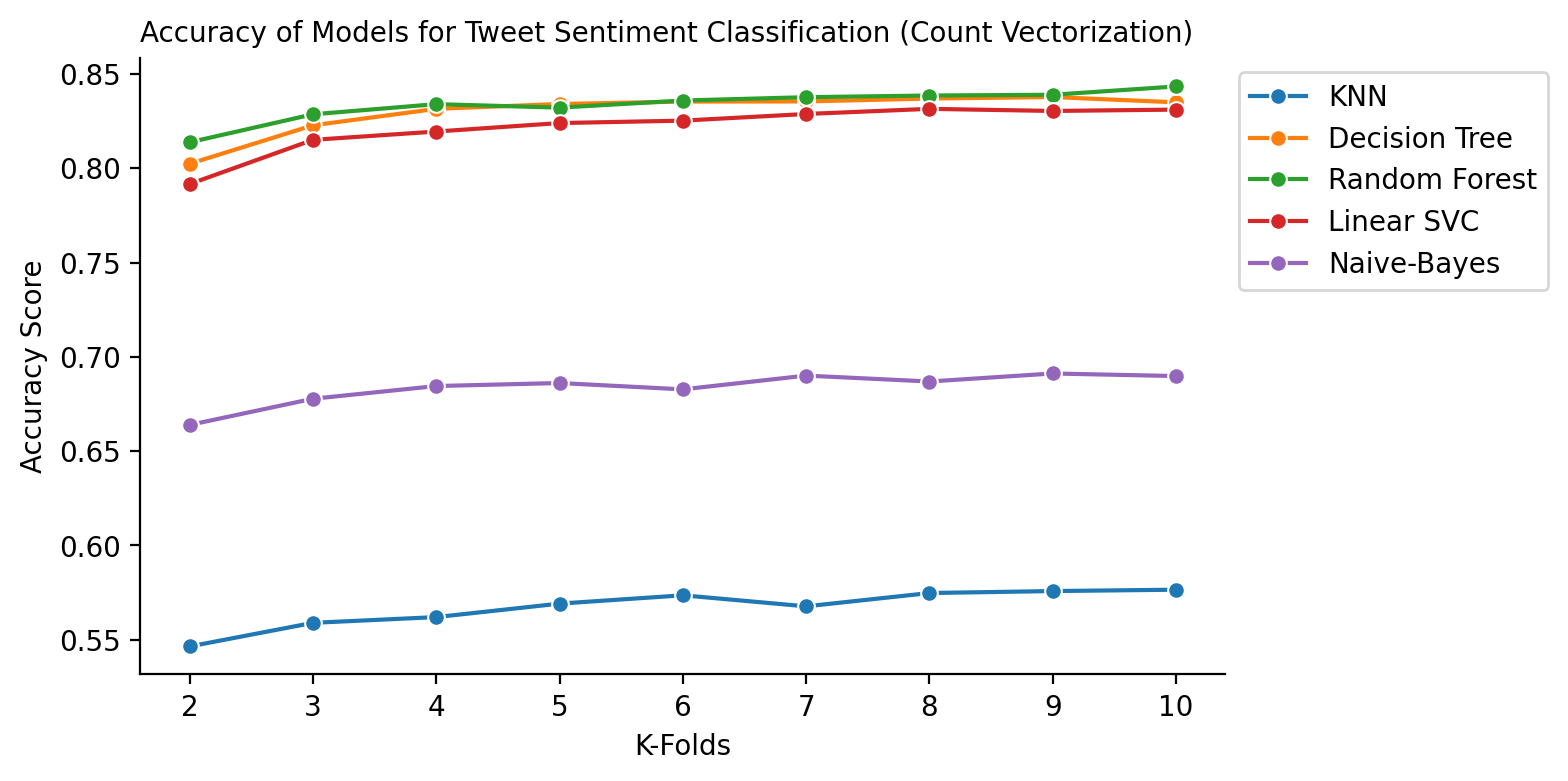

In [54]:
plt.figure(figsize=(7, 4))
sns.lineplot(data=all_models.query("model == 'knn'"), x="k_fold", y="acc_score", marker="o", label="KNN")
sns.lineplot(data=all_models.query("model == 'decision_tree'"), x="k_fold", y="acc_score", marker="o", label="Decision Tree")
sns.lineplot(data=all_models.query("model == 'random_forest'"), x="k_fold", y="acc_score", marker="o", label="Random Forest")
sns.lineplot(data=all_models.query("model == 'linear_svc'"), x="k_fold", y="acc_score", marker="o", label="Linear SVC")
sns.lineplot(data=all_models.query("model == 'naive_bayes'"), x="k_fold", y="acc_score", marker="o", label="Naive-Bayes")
plt.legend(fontsize=10, bbox_to_anchor=(1,1))
plt.xlabel("K-Folds", fontsize=10)
plt.ylabel("Accuracy Score", fontsize=10)
plt.title("Accuracy of Models for Tweet Sentiment Classification (Count Vectorization)", fontsize=10, loc="left")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

## TFIDF DTM

In [55]:
# Implement K-Folds, use classification accuracy as scoring metric
k_folds = 10
knn_tfidf_results = []

for k in range(2, k_folds + 1):

    # Initialize kfolds
    kf = KFold(n_splits=k, shuffle=True)

    k_fold_results = []

    # Split the dataset into train / test by k-fold index
    for (train_index, test_index) in kf.split(tfidf.toarray()):
        x_train = tfidf.toarray()[train_index]
        x_test = tfidf.toarray()[test_index]
        y_train = label[train_index]
        y_test = label[test_index]

        # Initialize KNN model - 3 neighbors only
        knn = KNeighborsClassifier(n_neighbors=3)

        # Train KNN model with 3 neighbors
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)

        k_fold_results.append(accuracy_score(y_test, y_pred))
    knn_tfidf_results.append((k, np.mean(k_fold_results)))

In [56]:
# KNN CV results
knn_tfidf_results

[(2, 0.4017004275369782),
 (3, 0.4103635318448924),
 (4, 0.4123686805101676),
 (5, 0.41477455238742256),
 (6, 0.41613905695837),
 (7, 0.417983476377637),
 (8, 0.4180617986086009),
 (9, 0.41678199680606415),
 (10, 0.4191894897674161)]

### Decision Tree Classifier

In [57]:
# Implement K-Folds, use classification accuracy as scoring metric
k_folds = 10
dt_tfidf_results = []

for k in range(2, k_folds + 1):

    # Initialize kfolds
    kf = KFold(n_splits=k, shuffle=True)

    k_fold_results = []

    # Split the dataset into train / test by k-fold index
    for (train_index, test_index) in kf.split(tfidf.toarray()):
        x_train = tfidf.toarray()[train_index]
        x_test = tfidf.toarray()[test_index]
        y_train = label[train_index]
        y_test = label[test_index]

        # Initialize model
        dt = DecisionTreeClassifier()

        # Train KNN model with 3 neighbors
        dt.fit(x_train, y_train)
        y_pred = dt.predict(x_test)

        k_fold_results.append(accuracy_score(y_test, y_pred))
    dt_tfidf_results.append((k, np.mean(k_fold_results)))

In [58]:
# Decision tree CV results
dt_cnt_vec_results

[(2, 0.802357555315939),
 (3, 0.8227324284705548),
 (4, 0.8314751746499279),
 (5, 0.8340412014908786),
 (6, 0.835326032138664),
 (7, 0.8354054704419668),
 (8, 0.8369303337035936),
 (9, 0.8377312752764017),
 (10, 0.8349248469199273)]

#### Random Forest Classification (Bagging)

In [59]:
# Implement K-Folds, use classification accuracy as scoring metric
k_folds = 10
rf_tfidf_results = []

for k in range(2, k_folds + 1):

    # Initialize kfolds
    kf = KFold(n_splits=k, shuffle=True)

    k_fold_results = []

    # Split the dataset into train / test by k-fold index
    for (train_index, test_index) in kf.split(tfidf.toarray()):
        x_train = tfidf.toarray()[train_index]
        x_test = tfidf.toarray()[test_index]
        y_train = label[train_index]
        y_test = label[test_index]

        # Initialize model
        rf = RandomForestClassifier()

        # Train KNN model with 3 neighbors
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)

        k_fold_results.append(accuracy_score(y_test, y_pred))
    rf_tfidf_results.append((k, np.mean(k_fold_results)))

In [60]:
# Random forest CV results
rf_tfidf_results

[(2, 0.8036418699542898),
 (3, 0.8192026992228866),
 (4, 0.8259404409048396),
 (5, 0.8302711907695999),
 (6, 0.8337202651401937),
 (7, 0.8350044116467474),
 (8, 0.8326780357706012),
 (9, 0.8346027462754297),
 (10, 0.8334809964460451)]

#### SVM (Linear SVC)

In [61]:
# Implement K-Folds, use classification accuracy as scoring metric
k_folds = 10
svc_tfidf_results = []

for k in range(2, k_folds + 1):

    # Initialize kfolds
    kf = KFold(n_splits=k, shuffle=True)

    k_fold_results = []

    # Split the dataset into train / test by k-fold index
    for (train_index, test_index) in kf.split(tfidf.toarray()):
        x_train = tfidf.toarray()[train_index]
        x_test = tfidf.toarray()[test_index]
        y_train = label[train_index]
        y_test = label[test_index]

        # Initialize model
        svc = LinearSVC()

        # Train KNN model with 3 neighbors
        svc.fit(x_train, y_train)
        y_pred = svc.predict(x_test)

        k_fold_results.append(accuracy_score(y_test, y_pred))
    svc_tfidf_results.append((k, np.mean(k_fold_results)))

In [62]:
# Linear SVC CV results
svc_tfidf_results

[(2, 0.7867169634997182),
 (3, 0.8038017710416887),
 (4, 0.813668459806527),
 (5, 0.8164750314513356),
 (6, 0.820567055127665),
 (7, 0.8235341301034732),
 (8, 0.8212090589981893),
 (9, 0.8244161863897123),
 (10, 0.8250576986694229)]

### Naive Bayes

#### Consolidate results

In [63]:
# Implement K-Folds, use classification accuracy as scoring metric
k_folds = 10
nb_tfidf_results = []

for k in range(2, k_folds + 1):

    # Initialize kfolds
    kf = KFold(n_splits=k, shuffle=True)

    k_fold_results = []

    # Split the dataset into train / test by k-fold index
    for (train_index, test_index) in kf.split(tfidf.toarray()):
        x_train = tfidf.toarray()[train_index]
        x_test = tfidf.toarray()[test_index]
        y_train = label[train_index]
        y_test = label[test_index]

        # Initialize model
        nb = MultinomialNB()

        # Train KNN model with 3 neighbors
        nb.fit(x_train, y_train)
        y_pred = nb.predict(x_test)

        k_fold_results.append(accuracy_score(y_test, y_pred))
    nb_tfidf_results.append((k, np.mean(k_fold_results)))

In [64]:
# Naive-Bayes CV results
nb_tfidf_results

[(2, 0.6766660047443258),
 (3, 0.6798750457006278),
 (4, 0.6813997106018879),
 (5, 0.6863719135311028),
 (6, 0.6867727168745054),
 (7, 0.689339857223069),
 (8, 0.6855703888391641),
 (9, 0.6899798512313554),
 (10, 0.6915059706698967)]

In [65]:
# KNN
knn_score_new_tfidf = []
for knn in knn_tfidf_results:
    knn2 = ("knn",) + knn
    knn_score_new_tfidf.append(knn2)

# Decision tree
dt_score_new_tfidf = []
for dt in dt_tfidf_results:
    dt2 = ("decision_tree",) + dt
    dt_score_new_tfidf.append(dt2)

# Random forest
rf_score_new_tfidf = []
for rf in rf_tfidf_results:
    rf2 = ("random_forest",) + rf
    rf_score_new_tfidf.append(rf2)

# SVM classifier
svc_score_new_tfidf = []
for svc in svc_tfidf_results:
    svc2 = ("linear_svc",) + svc
    svc_score_new_tfidf.append(svc2)

# Naive Bayes
nb_score_new_tfidf = []
for nb in nb_tfidf_results:
    nb2 = ("naive_bayes",) + nb
    nb_score_new_tfidf.append(nb2)

# Construct dataframe to store the results
knn = pd.DataFrame(knn_score_new_tfidf)
dt = pd.DataFrame(dt_score_new_tfidf)
rf = pd.DataFrame(rf_score_new_tfidf)
svc = pd.DataFrame(svc_score_new_tfidf)
nb = pd.DataFrame(nb_score_new_tfidf)
all_models_tfidf = pd.concat([knn, dt, rf, svc, nb], axis=0)
all_models_tfidf.columns = ["model", "k_fold", "acc_score"]

all_models_tfidf["log_acc_score"] = np.log(all_models_tfidf["acc_score"])

#### Visualize results

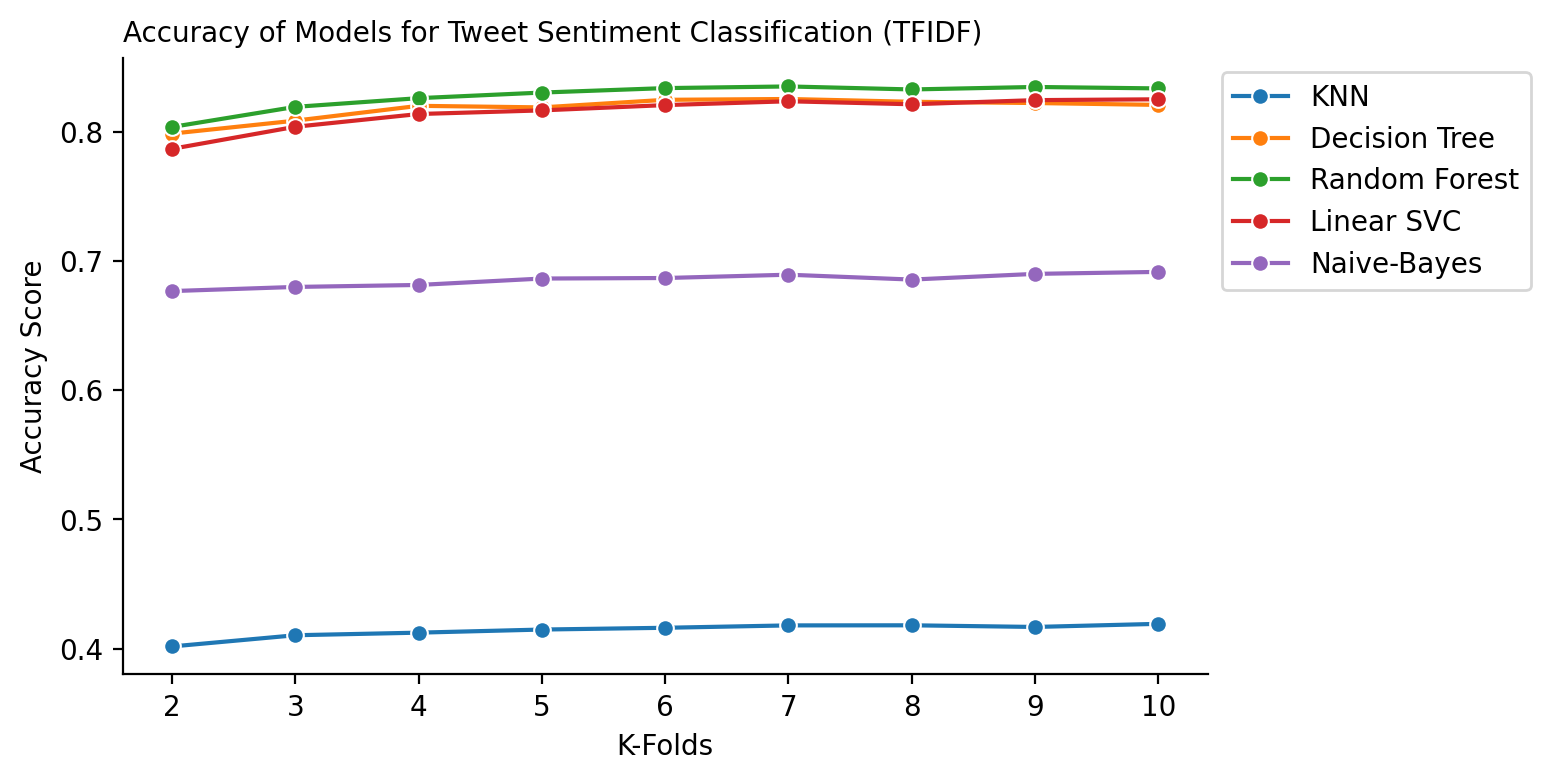

In [72]:
plt.figure(figsize=(7, 4))
sns.lineplot(data=all_models_tfidf.query("model == 'knn'"), x="k_fold", y="acc_score", marker="o", label="KNN")
sns.lineplot(data=all_models_tfidf.query("model == 'decision_tree'"), x="k_fold", y="acc_score", marker="o", label="Decision Tree")
sns.lineplot(data=all_models_tfidf.query("model == 'random_forest'"), x="k_fold", y="acc_score", marker="o", label="Random Forest")
sns.lineplot(data=all_models_tfidf.query("model == 'linear_svc'"), x="k_fold", y="acc_score", marker="o", label="Linear SVC")
sns.lineplot(data=all_models_tfidf.query("model == 'naive_bayes'"), x="k_fold", y="acc_score", marker="o", label="Naive-Bayes")
plt.legend(fontsize=10, bbox_to_anchor=(1,1))
plt.xlabel("K-Folds", fontsize=10)
plt.ylabel("Accuracy Score", fontsize=10)
plt.title("Accuracy of Models for Tweet Sentiment Classification (TFIDF)", fontsize=10, loc="left")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

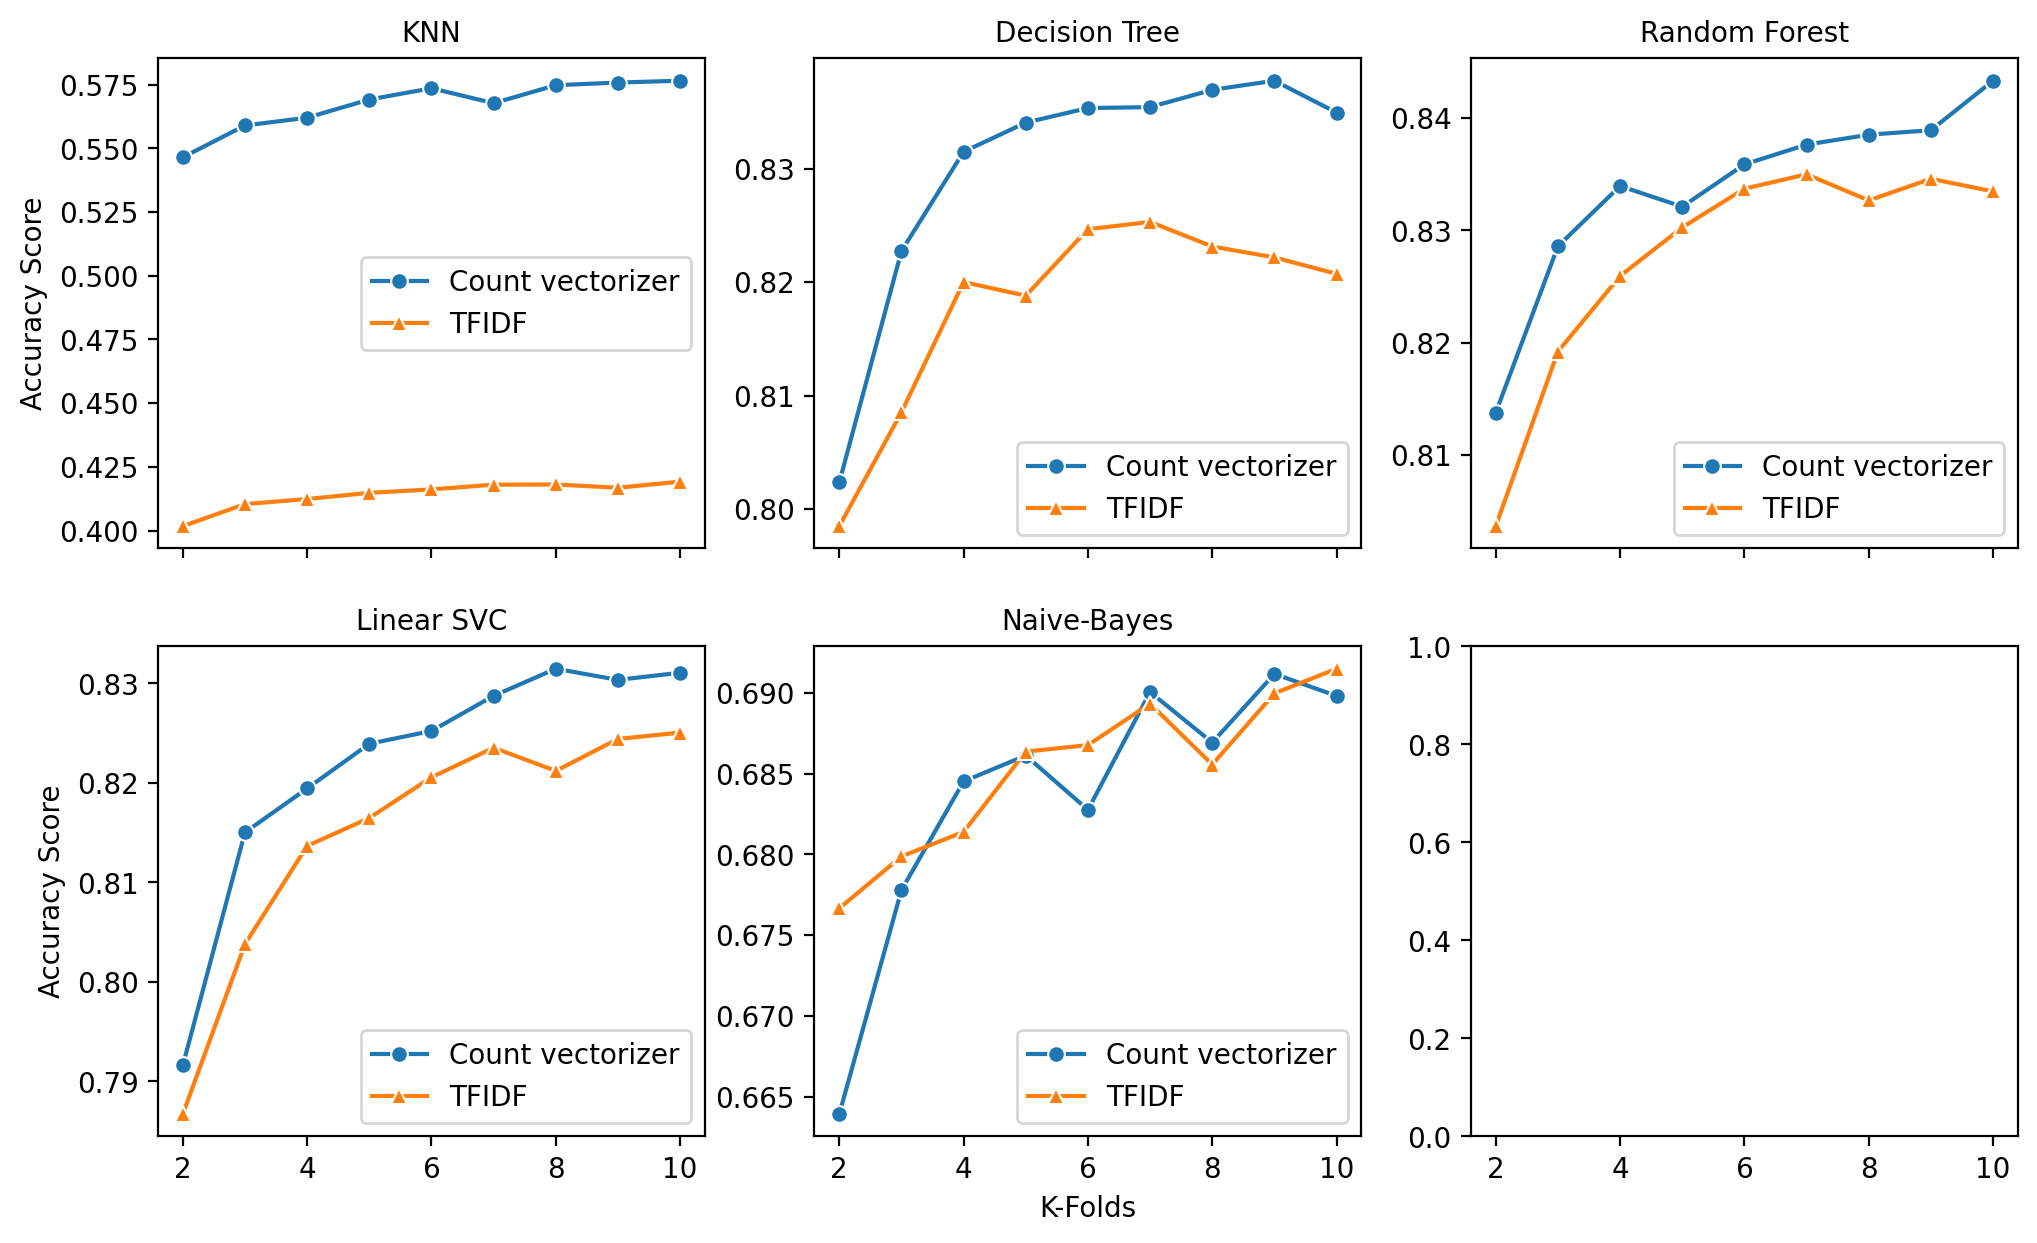

In [76]:
# Compare between word embedding technique
fig, ax = plt.subplots(2, 3, figsize=(12, 7), sharex=True)
sns.lineplot(data=all_models.query("model == 'knn'"), x="k_fold", y="acc_score", marker="o", label="Count vectorizer", ax=ax[0, 0])
sns.lineplot(data=all_models_tfidf.query("model == 'knn'"), x="k_fold", y="acc_score", marker="^", label="TFIDF", ax=ax[0, 0])
sns.lineplot(data=all_models.query("model == 'decision_tree'"), x="k_fold", y="acc_score", marker="o", label="Count vectorizer", ax=ax[0, 1])
sns.lineplot(data=all_models_tfidf.query("model == 'decision_tree'"), x="k_fold", y="acc_score", marker="^", label="TFIDF", ax=ax[0, 1])
sns.lineplot(data=all_models.query("model == 'random_forest'"), x="k_fold", y="acc_score", marker="o", label="Count vectorizer", ax=ax[0, 2])
sns.lineplot(data=all_models_tfidf.query("model == 'random_forest'"), x="k_fold", y="acc_score", marker="^", label="TFIDF", ax=ax[0, 2])
sns.lineplot(data=all_models.query("model == 'linear_svc'"), x="k_fold", y="acc_score", marker="o", label="Count vectorizer", ax=ax[1, 0])
sns.lineplot(data=all_models_tfidf.query("model == 'linear_svc'"), x="k_fold", y="acc_score", marker="^", label="TFIDF", ax=ax[1, 0])
sns.lineplot(data=all_models.query("model == 'naive_bayes'"), x="k_fold", y="acc_score", marker="o", label="Count vectorizer", ax=ax[1, 1])
sns.lineplot(data=all_models_tfidf.query("model == 'naive_bayes'"), x="k_fold", y="acc_score", marker="^", label="TFIDF", ax=ax[1, 1])
ax[0, 0].set_title("KNN", fontsize=10)
ax[0, 1].set_title("Decision Tree", fontsize=10)
ax[0, 2].set_title("Random Forest", fontsize=10)
ax[1, 0].set_title("Linear SVC", fontsize=10)
ax[1, 1].set_title("Naive-Bayes", fontsize=10)
ax[0, 0].set_ylabel("Accuracy Score")
ax[0, 1].set_ylabel("")
ax[0, 2].set_ylabel("")
ax[1, 1].set_ylabel("")
ax[1, 0].set_ylabel("Accuracy Score")
ax[1, 0].set_xlabel("")
ax[1, 1].set_xlabel("K-Folds")
plt.show()